<a href="https://colab.research.google.com/github/have-aniceday/AI_vision/blob/master/VGGNet(crop8*8%2C%20dropout%2C%20batch%20258-128%2C%20512).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [14]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [16]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


 deer horse truck  deer


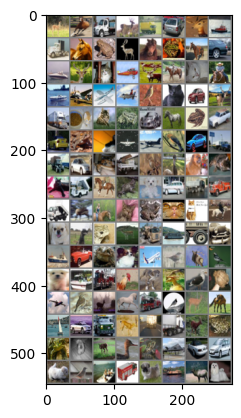

In [17]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [18]:
# VGG Model

cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
       'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
       'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
       'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self.make_layers(cfg[vgg_name])
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


net = VGG('VGG11').to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [19]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) ##L2 정규화와 같은 정규화 기법을 사용하여 과적합을 방지
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already defined trainloader and testloader

epochs = 80  # number of epochs
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    # Training phase
    net.train()  # Set the network to training mode
    total_train = 0
    correct_train = 0
    epoch_loss_train = 0.0
    for i, data in enumerate(trainloader, start=0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss_train += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss.append(epoch_loss_train / len(trainloader))
    train_accuracy.append(100 * correct_train / total_train)

    # Testing phase
    net.eval()  # Set the network to evaluation mode
    total_test = 0
    correct_test = 0
    epoch_loss_test = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_loss_test += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss.append(epoch_loss_test / len(testloader))
    test_accuracy.append(100 * correct_test / total_test)

    # Update learning rate
    scheduler.step()

    # Print stats
    print(f'Epoch {epoch+1}/{epochs} Train loss: {train_loss[-1]:.3f} Train Acc: {train_accuracy[-1]:.2f}% Test loss: {test_loss[-1]:.3f} Test Acc: {test_accuracy[-1]:.2f}%')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), test_loss, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/80 Train loss: 2.071 Train Acc: 16.38% Test loss: 2.033 Test Acc: 16.06%
Epoch 2/80 Train loss: 2.047 Train Acc: 17.38% Test loss: 1.959 Test Acc: 18.87%
Epoch 3/80 Train loss: 1.989 Train Acc: 18.14% Test loss: 1.972 Test Acc: 19.29%
Epoch 4/80 Train loss: 1.954 Train Acc: 19.36% Test loss: 2.023 Test Acc: 19.60%
Epoch 5/80 Train loss: 1.915 Train Acc: 22.10% Test loss: 1.841 Test Acc: 25.74%
Epoch 6/80 Train loss: 1.863 Train Acc: 23.65% Test loss: 1.830 Test Acc: 24.60%
Epoch 7/80 Train loss: 1.799 Train Acc: 25.46% Test loss: 1.718 Test Acc: 27.58%
Epoch 8/80 Train loss: 1.752 Train Acc: 27.48% Test loss: 1.719 Test Acc: 28.54%
Epoch 9/80 Train loss: 1.695 Train Acc: 29.77% Test loss: 1.682 Test Acc: 30.74%
Epoch 10/80 Train loss: 1.636 Train Acc: 32.95% Test loss: 1.636 Test Acc: 33.78%
Epoch 11/80 Train loss: 1.534 Train Acc: 37.19% Test loss: 1.490 Test Acc: 39.57%
Epoch 12/80 Train loss: 1.458 Train Acc: 40.00% Test loss: 1.448 Test Acc: 42.62%
Epoch 13/80 Train loss: 1

In [ ]:
inputs.shape

In [ ]:
# Train the model
epochs = 80  # number of epochs

train_loss = []
test_loss = []
for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

# train이랑 test 어케 돌아가는지 그래프를 그려봅시다

In [ ]:
train_accuracy=[]
test_accuracy=[]

